In [1]:
import itertools
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats, optimize

https://stackoverflow.com/questions/78386497/fixed-params-in-convolved-gaussian-fit

In [2]:
data = pd.read_csv("20240402_In.mca", encoding="latin-1", names=["y"]).loc[12:2058]
data["y"] = pd.to_numeric(data["y"])
data["y"] /= data["y"].max()
data["x"] = -0.0188026396003431 + 0.039549044037714 * data.index

In [3]:
data = data.loc[(23.5 <= data["x"]) & (data["x"] <= 29.), :]

In [4]:
def peak(x, A, s, x0):
    law = stats.norm(loc=x0, scale=s)
    return A * law.pdf(x) / law.pdf(x0)

In [5]:
def model(x, *parameters):
    n = len(parameters) // 3
    y = np.zeros_like(x)
    for i in range(n):
        y += peak(x, *parameters[(i * 3):((i + 1) * 3)])
    return y

In [6]:
indices, bases = signal.find_peaks(data.y, prominence=0.0125)
indices, bases

(array([ 30, 107, 122]),
 {'prominences': array([0.99761526, 0.18918919, 0.03338633]),
  'left_bases': array([  5,  91, 117]),
  'right_bases': array([ 72, 131, 131])})

In [7]:
x0s = data.x.values[indices]
As = bases["prominences"]
ss = (data.x.values[bases["right_bases"]] - data.x.values[bases["left_bases"]]) / 8.

In [8]:
p0 = list(itertools.chain(*zip(As, ss, x0s)))

In [9]:
p0

[0.9976152623211447,
 0.33122324381585466,
 24.699349883970907,
 0.1891891891891892,
 0.19774522018856988,
 27.744626274874886,
 0.033386327503974564,
 0.06921082706599968,
 28.337861935440593]

In [10]:
popt, pcov = optimize.curve_fit(model, data.x, data.y, p0=p0)
popt

array([ 0.99391974,  0.16021049, 24.65586218,  0.18533265,  0.12188248,
       27.78078373,  0.03678059,  0.12189041, 28.35838493])

In [13]:
xlin = np.linspace(data.x.min(), data.x.max(), 400)

In [14]:
yhat = model(xlin, *popt)

In [21]:
As = [1, 0.5538, 0.1673, 0.1673 * 0.5185]
x0s = [24.210, 24.002, 27.276, 27.238] 

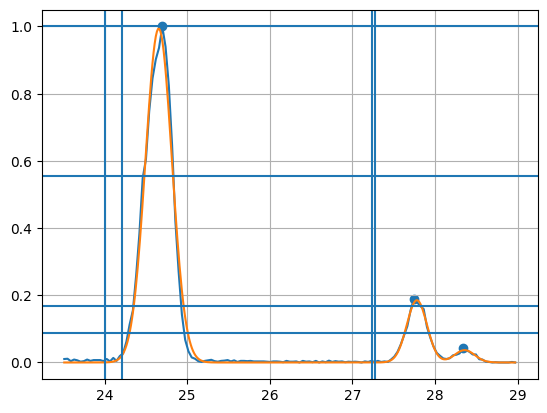

In [25]:
fig, axe = plt.subplots()
axe.plot(data.x, data.y)
axe.scatter(data.x.values[indices], data.y.values[indices])
axe.plot(xlin, yhat)
for A in As:
    axe.axhline(A)
for x0 in x0s:
    axe.axvline(x0)
axe.grid()